In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pickle

import os
import re
from collections import OrderedDict

import seaborn as sns
sns.set_theme(font_scale=1.5);

In [16]:
Earray   = np.round(np.logspace(np.log10(0.250), np.log10(10000), 100), 2)
h        = np.linspace(0, 499, 500);
#h        = np.linspace(0, 999, 1000)
binWidth = np.hstack([np.diff(Earray), np.diff(Earray)[-1]]);

'''
def normFactor(ang):
    if ang != 0:
        return 1e4 * 2 * np.pi * np.sin(np.deg2rad(ang))
    else:
        return 1e4 * np.pi * np.sin(np.deg2rad(1))
'''; 

def normFactor(ang):
    #return 1e4 * 4 * np.pi * (np.sin(np.deg2rad(ang)) * np.cos(np.deg2rad(ang)))
    return 1;

def ProcessIoniData(data):
    
    lineNo = 1000
    
    nRuns  = int(len(data)/lineNo)
        
    if nRuns != 40:
        print("Actually %.0f runs!" % (nRuns) )
    
    '''
    mean = np.zeros([1000])
    std  = np.zeros([1000])
    for i in range(0, nRuns):
        
        mean += data.E.values[i*lineNo:(i+1)*lineNo]
        
        std  += (data.E.values[i*lineNo:(i+1)*lineNo])**2
    ''';
    
    # 100,000x faster than the above lines
    tmp = data.E.values.reshape(lineNo, nRuns, order='F')
    mean = np.sum(tmp, axis=1)
    std  = np.sum(tmp**2, axis=1)
        
    
    std = std - (mean/nRuns)**2
    
    std[std < 0] = 0
    
    std = np.sqrt(1/(nRuns-1) * std)
    
    return mean, std

def ProcessSpectralData(data):
    
    lineNo = 1000
    
    data.fillna(0, inplace=True)
    
    N = 40000 - len(data)

    for _ in range(0, N):
        data = data.append(data.iloc[0], ignore_index=True)
    
    nRuns  = int(len(data)/lineNo)
    
    if nRuns != 40:
        print("Actually %.0f runs!" % (nRuns) )
        

    
    mean = np.zeros([lineNo, 100]);
    std  = np.zeros([lineNo, 100]);
    for i in range(0, nRuns):
        mean += data.values[lineNo*i:lineNo*(i+1), :]
        std  += (data.values[lineNo*i:lineNo*(i+1), :])**2
    
    '''
    tmp = data.values.reshape(lineNo, 100, nRuns, order='A')

    mean = np.sum(tmp, axis=2)
    std  = np.sum(tmp**2, axis=2)
    ''';

    
    # slower than -= but necessesary to prevent casting error
    std = std - (np.divide( mean, float(nRuns)) )**2
    
    std[std < 0] = 0
    
    std = np.sqrt(1/(float(nRuns)-1) * std)
    
    return mean/binWidth, std/binWidth

From sin(a$\alpha$) from $\alpha \in [0, 45^\circ]$,

$$N_{n=1} = 2 \pi \int_{0}^{45^\circ} sin^2(\alpha)~ d\alpha = 0.89660$$

$$\frac{1}{2\pi N_n} \frac{d^3 N}{dt ~dA ~d\Omega} = f_0 \rightarrow \frac{N}{2\pi N_n} = f_0$$

# Mono-pitch angle normalization


$$dN = -dt ~d\Omega_s ~f(\hat k_s)\hat k_s \cdot dA_d \hat k_d ~ [\hat k_s \cdot \hat k_d < 0]$$

$$-\frac{dN}{dt~dA} [cm^{-2} sec^{-1}] = \int_\theta \int_\phi \sin(\phi) ~d\theta ~d\phi ~f(\hat k_s)~ [\hat k_s \cdot \hat k_d < 0]$$

$$\frac{dN}{dt~dA} [cm^{-2} sec^{-1}] = 2\pi~ \int_{\phi=0}^{\pi/2}d\phi ~\sin(\phi) ~f(\hat k_s)$$

We let $f(\hat k_s) = f_0~ \delta(\phi - \phi_0)$, which leads to

$$\frac{dN}{dt~dA} = 2\pi~f_0 \int_0^{\pi/2} \sin(\phi)~ \delta(\phi - \phi_0) ~d\phi = 2\pi~f_0 ~~H(\phi - \phi_0) \sin(\phi_0)|_{0}^{\pi/2}$$

$$\frac{dN}{dt~dA} = \begin{cases}2\pi~f_0 sin(\phi_0) ~~,&  \phi_0 \in (0, ~\pi/2) \\ ~~ & ~~\\ \pi~f_0 \sin(\phi_0)   ~~,& \phi_0 = 0 ~~or~~ \phi_0 = \pi/2 \end{cases}$$

Therefor, in order to normalize flux to some fixed flux, we can write

$$f_0 ~[cm^{-2} sec^{-1}]= \frac{N_{particles}}{2\pi~sin(\phi_0)}$$

at mono-pitch angle run $\phi = \phi_0$.

In [17]:
def unbuild_table(table):

    import itertools

    return np.array(list(itertools.islice(table.items(), len(table))))

def build_table(path, energyDist):
    
    
    counter = 0

    files = os.listdir(path)
    
    #D = OrderedDict()
    D = {}
    
    files = [f for f in files if energyDist in f]
    
    for file in files:
        tmp = file.split('_')
        
        counter += 1
        
        particle = tmp[0]
        fileType = tmp[1]
        E = int(re.findall(r'\d+', file)[0])
        PAD_ang = int(re.findall(r'\d+', tmp[-1].split('.')[0])[0])
        
        #print(file, particle, fileType, E, PAD_ang)

        if fileType == "ene":
            fileType = "spectra"
            readIn = pd.read_csv(path + file, names=range(0,100), #names=Earray, 
                                 header=None, sep=',', engine='c', nrows=40000)
            
            #assert len(readIn) == 40000, f"Error in file: {file}, len() = {len(readIn)}"
            mean, std = np.divide(ProcessSpectralData(readIn), normFactor(PAD_ang))
            
            mean = mean[:500, :]
            std  = std[:500, :]

        elif fileType == "dep":
            fileType = "ioni"
            readIn = pd.read_csv(path + file, names=['E'], 
                                 header=None, sep=',', engine='c', nrows=40000)
            
            #assert len(readIn) == 40000, f"Error in file: {file}, len() = {len(readIn)}"
            mean, std = np.divide(ProcessIoniData(readIn), normFactor(PAD_ang)) / (19 * PAD_ang)
            mean = mean[:500]
            std  = std[:500]

        D[(particle, fileType, E, PAD_ang)] = (mean, std)
        
        #if counter > 10:
        #    break
        
    return D

#%timeit -n 3 D_mono = build_table("../data/PADruns/", "mono")
D_mono = build_table("../data/PADruns_test7/", "mono")

/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


In [5]:
%load_ext line_profiler

In [31]:
%lprun -f build_table -f ProcessIoniData -f ProcessSpectralData build_table("../data/PADruns/", "mono")

In [ ]:
filename = "G4data_mono_discretePAD.pkl"

try:
    with open(filename, 'wb') as f:
        pickle.dump(D_mono, f, protocol=pickle.HIGHEST_PROTOCOL)

    del D_mono
    
except(NameError):
    pass

D_mono = pickle.load(open(filename, 'rb'))

#!cp G4data_sin45_mono.pkl G4data_sin45_exp.pkl ../../G4EPP-git/G4EPP/data/

[   10    20    50   100   200   500  1000  2000  5000 10000]


/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply


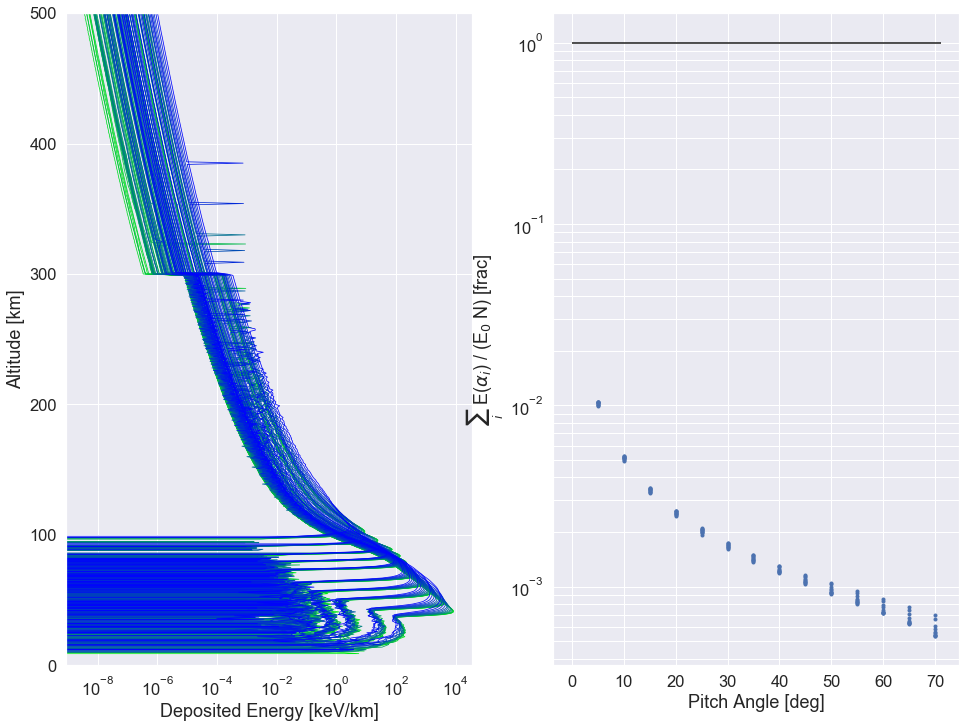

In [23]:
from scipy.signal import savgol_filter

ang_end = np.max([int(x) for x in np.array(list(D_mono.keys()))[:,3]]) + 1

run_list = np.unique([int(x) for x in np.array(list(D_mono.keys()))[:,2]])

print(run_list)

X, Y = np.meshgrid(np.linspace(0, ang_end, ang_end), run_list)

ene = 100

st = ['-', '--', ':']

plt.figure(figsize=(16,12)); plt.subplot(1,2,1); plt.grid(True, which='both')
for i in range(0, ang_end, 5):
    for ene in run_list:
    #for j, ene in enumerate([10, 100, 10000]):

        if i % 10 == 0:
            label = '%.0f$^\circ$, E$_0$ = %.0f keV' % (i, ene)
        else:
            label=None

        plt.semilogx(D_mono[('electron', 'ioni', ene, i)][0] * np.sin(np.deg2rad(i)), h, 
                         label=label, linewidth=0.75, c=[0, 1-i/ang_end, i/ang_end])




#plt.legend();
plt.ylim([0, 500]);
plt.ylabel('Altitude [km]');
plt.xlabel('Deposited Energy [keV/km]');
#plt.legend();
        
plt.subplot(1,2,2); 
plt.grid(True, which='both');
for i in range(0,ang_end, 5):
    for ene in run_list:
        if i == 0:
            label=ene
    #for ene in [2000, 5000, 10000]:
        plt.plot(i, np.sum(D_mono[('electron', 'ioni', ene, i)][0])/(ene*1e4), 'b.', label=label)

plt.yscale('log')
#plt.plot(np.arange(0, ang_end), 19 * np.arange(0, ang_end))
#plt.yscale('log')
plt.ylabel('$\sum_i$ E($\\alpha_i$) / (E$_0$ N) [frac]')
plt.xlabel('Pitch Angle [deg]');
plt.hlines(1, 0, ang_end)
#plt.legend();


#plt.plot(np.arange(5, ang_end), 95 + 1/np.tan(np.deg2rad(np.arange(5,ang_end))))

'''
plt.figure(figsize=(8,8));
for i in range(0, ang_end):
    #for ene in run_list:
    try:
        plt.plot(i, np.sum(D_mono[('electron', 'ioni', ene, i)][0]), '.')
    except(KeyError):
        pass
    
plt.xlabel(r'Pitch Angle $\alpha_0$ [deg]');
plt.ylabel('Altitude of Ionization Maximum [km]');
''';

In [9]:
arr = np.zeros([ang_end, 1000, len(run_list)])
for i in range(0, ang_end):
    for j, ene in enumerate(run_list):
        arr[i, :, j] = D_mono[('electron', 'ioni', ene, i)][0] + D_mono[('photon', 'ioni', ene, i)][0]

In [30]:
print(np.shape(arr))

(71, 1000, 10)


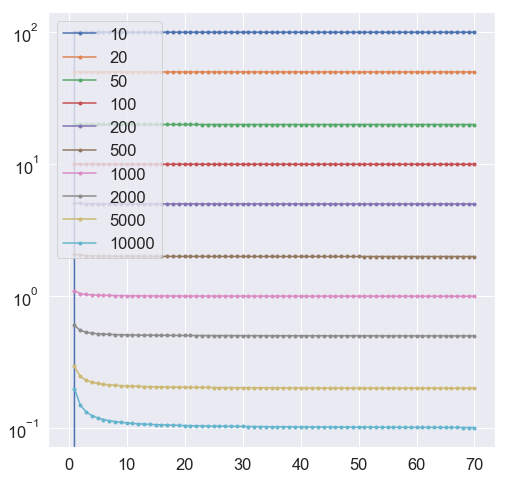

In [10]:
plt.figure(figsize=(8,8))
plt.plot(np.arange(0, ang_end), 
         np.divide(np.nansum(arr, axis=1), (1e4 * run_list)), '.-');
plt.legend(run_list)
plt.yscale('log')

No handles with labels found to put in legend.


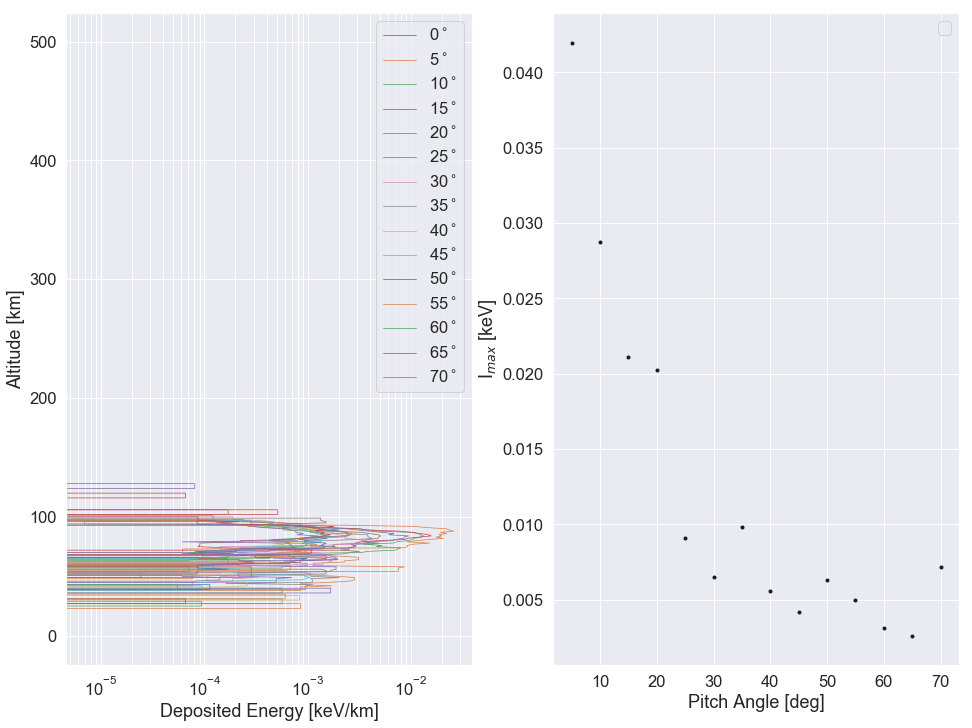

In [19]:
from scipy.signal import savgol_filter

energy = 100

plt.figure(figsize=(16,12)); plt.subplot(1,2,1); plt.grid(True, which='both')
#for i in [0, 70]:
for i in range(0, ang_end, 5):
    if i % 5 == 0:
        label = '%.0f$^\circ$' % i
    else: 
        label = None
    plt.semilogx(savgol_filter(D_mono[('photon', 'ioni', energy, i)][0] , 5, 0), h, 
                 label=label, linewidth=0.75)
    
    #print("%.0f deg ~ %.3e keV/part" % 
    #      (i, np.sum(D_mono[('photon', 'ioni', energy, i)][0])))

plt.legend();
plt.ylabel('Altitude [km]');
plt.xlabel('Deposited Energy [keV/km]');


plt.subplot(1,2,2); plt.grid(True, which='both');

for i in range(0,ang_end, 5):
    plt.plot(i, np.max(D_mono[('photon', 'ioni', energy, i)][0]) , 'k.')
        
#plt.plot(range(0, ang_end), 0.1/np.cos(np.deg2rad(np.arange(0, ang_end))))
    
plt.ylabel('I$_{max}$ [keV]');
plt.xlabel('Pitch Angle [deg]');
plt.legend();

KeyError: ('photon', 'ioni', 100, 1)

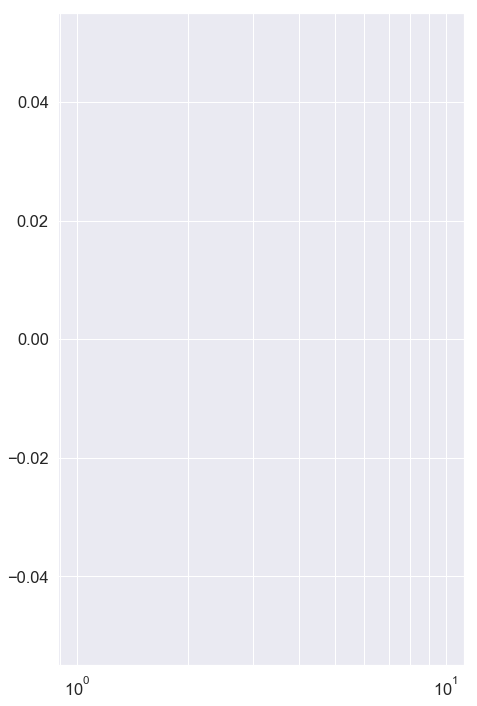

In [14]:
from scipy.signal import savgol_filter

energy = 10

plt.figure(figsize=(16,12)); plt.subplot(1,2,1); plt.grid(True, which='both')
#for i in [0, 70]:
for i in range(0, 10):
    for ene in [100, 1000, 10000]:
        if i % 5 == 0:
            label = '%.1f MeV, %.0f$^\circ$' % (ene/1e3, i)
        else: 
            label = None
        plt.semilogx(savgol_filter(D_mono[('photon', 'ioni', ene, i)][0] +
                                   D_mono[('electron', 'ioni', ene, i)][0], 1, 0) / ene, h,
                     label=label, linewidth=0.75)
    

plt.legend();
#plt.yscale('log')
#plt.ylim(1.5e1, 150)
#plt.yscale('log')
#plt.ylim([1e1, 300]);
#plt.xlim([1e-6, 1e4]);
plt.ylabel('Altitude [km]');
plt.xlabel('Deposited Energy [keV/km]');

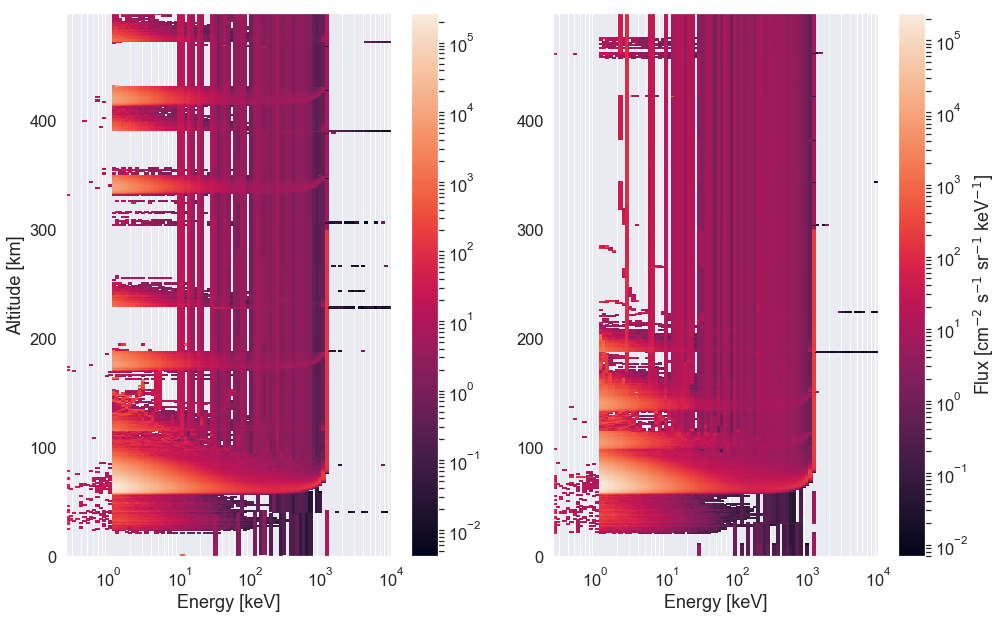

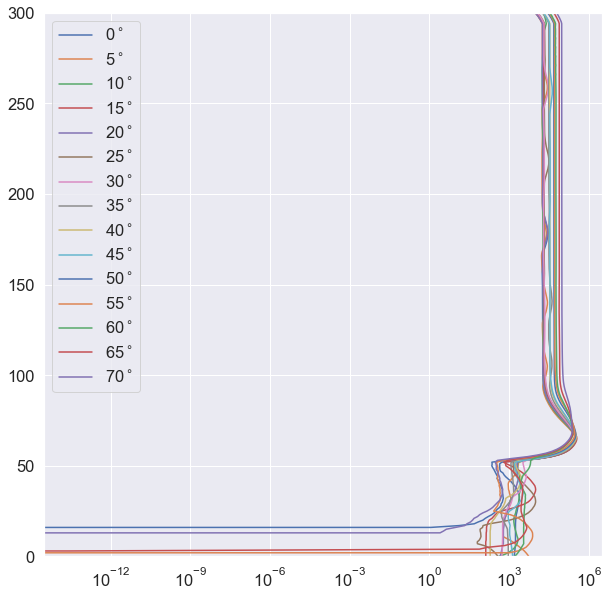

In [20]:
from matplotlib.colors import LogNorm

X,Y = np.meshgrid(Earray, h);


ang1 = 0

plt.figure(figsize=(16,10)); 
plt.subplot(1,2,1); plt.grid(True, which='both')
plt.pcolormesh(X, Y, D_mono[('electron', 'spectra', 1000, ang1)][0], 
               norm=LogNorm());
plt.colorbar();
plt.xscale('log');
plt.xlabel('Energy [keV]');
plt.ylabel('Altitude [km]');

ang2 = 35

plt.subplot(1,2,2); plt.grid(True, which='both')
plt.pcolormesh(X, Y, D_mono[('electron', 'spectra', 1000, ang2)][0], 
               norm=LogNorm());
plt.colorbar(label='Flux [cm$^{-2}$ s$^{-1}$ sr$^{-1}$ keV$^{-1}$]');
plt.xscale('log');
plt.xlabel('Energy [keV]');

plt.figure(figsize=(10,10)); plt.grid(True, which='both')
for i in range(0, ang_end, 5):
    plt.plot(savgol_filter(np.trapz(D_mono[('electron', 'spectra', 1000, i)][0], x=Earray), 11, 1),
             h, label='%.0f$^\circ$' % i)

#plt.hlines(79, 1e-2, 1e3, linewidth=1)
#plt.hlines(78, 1e-2, 1e3, linewidth=1)
plt.xscale('log');
plt.ylim(0, 300);
plt.legend();